## Feature selection: categorical

__Notes__: you'll need to ammend the sys path for your setup. 

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectFromModel

import os
#os.environ["PATH"] += os.pathsep + 'C:\\Users\\jander33\\Desktop\\project_5\\programs\\graphviz\\bin'


import sys
sys.path.append('../code/quickpipeline')
sys.path.append('../code/cleaners')
sys.path.append('../code/features')
#sys.path.append(r'C:\\Users\\jander33\\Desktop\\project_5\\programs')
#sys.path.append(r'C:\Miniconda3\envs\tf\Lib\site-packages')

#print(sys.path)
from quickpipeline import QuickPipeline
from J_cleaner import *
from j_features import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [7]:
df = pd.read_csv('../data/processed2/class_dfs/WR_27_cat.csv')
df.drop(['Unnamed: 0', 'Line'], axis = 1, inplace = True)


In [8]:
data = pd.read_csv('../data/processed2/WR_27_p2.csv')
data.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [9]:
# For some reason, the '<' seemed to be causing issues
dict1 = {'c.<40': 'medium',
'd.<70': 'high',  
'b.<15': 'lowest',    
'b.<25': 'low',     
'e.70+': 'highest',     
}

dict2 = {'b.<1800': 'medium',
'd.<11300': 'high',  
'c.<4250': 'low',    
'e.11300+ ': 'highest'         
}

In [10]:
df['LOC_BLD_AGE_bkt'] = df['LOC_BLD_AGE_bkt'].map(dict1)
df['LOC_BLD_AGE_bkt'].value_counts()

medium     7251
high       7240
lowest     5352
low        4895
highest    3367
Name: LOC_BLD_AGE_bkt, dtype: int64

In [11]:
df['SUM_BLD_SQFTAGE_bkt'] = df['SUM_BLD_SQFTAGE_bkt'].map(dict2)
df['SUM_BLD_SQFTAGE_bkt'].value_counts()

medium    16351
high       4465
low        3824
Name: SUM_BLD_SQFTAGE_bkt, dtype: int64

In [12]:
y = data[['TRV.Win']]

In [13]:
y['TRV.Win'].value_counts()

0    19790
1     8315
Name: TRV.Win, dtype: int64

In [14]:
j_factors('earlyshop_mth_bkt', df, 15)

Number of factors:  6 

a.0         13130
b.1         10027
c.2          3348
d.3           987
f.others      341
e.4           272
Name: earlyshop_mth_bkt, dtype: int64


In [15]:
df['SPRNKL_IND_bkt'] = df['SPRNKL_IND_bkt'].map({'b.N':'N', 'a.Y':'Y'})

In [16]:
df['earlyshop_mth_bkt'] = df['earlyshop_mth_bkt'].map({'a.0':'0', 'b.1':'1', 'c.2': '2', 'd.3': '3',
                                                      'e.4': '4', 'f.others': 'others'})

Pipeline rejects the numerical or tries to scale them

In [17]:
df['FirstQuoteYear'] = df['FirstQuoteYear'].apply(lambda x: str(x))

In [18]:
df['FirstEffYear'] = df['FirstEffYear'].apply(lambda x: str(x))

In [19]:
#df['bld_ind'] = df['bld_ind'].apply(lambda x: str(x))

In [20]:
df.Region.value_counts()

WESTERN           6950
MID-ATLANTIC      5452
SOUTHERN          4481
NORTHEAST         4463
SOUTH CENTRAL     3177
CENTRAL           2932
CALIFORNIA         637
NATIONAL DIST.      13
Name: Region, dtype: int64

In [21]:
df['csf'] = df.State.map(csf)
df['market_sh'] = df.State.map(market_sh)
df['div'] = df.State.map(div)

In [22]:
df.columns

Index(['UWC', 'Region', 'State', 'Segment', 'FirstQuoteYear', 'FirstEffYear',
       'mnln_cd', 'coast_ind', 'earlyshop_mth_bkt', 'SPRNKL_IND_bkt',
       'SUM_BLD_SQFTAGE_bkt', 'LOC_BLD_AGE_bkt', 'bld_ind', 'csf', 'market_sh',
       'div'],
      dtype='object')

In [23]:
df.head()

,UWC,Region,State,Segment,FirstQuoteYear,FirstEffYear,mnln_cd,coast_ind,earlyshop_mth_bkt,SPRNKL_IND_bkt,SUM_BLD_SQFTAGE_bkt,LOC_BLD_AGE_bkt,bld_ind,csf,market_sh,div
0,HUNT VALLEY,MID-ATLANTIC,VA,RESTAURANTS,2017,2017,MULTI,N,0,N,medium,medium,0,0,none,none
1,KANSAS CITY,SOUTH CENTRAL,MO,BUILDING,2018,2018,MPAC,N,1,N,NaN,low,1,1,low,low
2,NAPERVILLE,CENTRAL,TN,OFFICE,2017,2018,MULTI,N,3,N,medium,medium,1,0,none,none
3,CHARLOTTE,SOUTHERN,AL,OFFICE,2017,2018,MPAC,N,2,N,medium,high,0,0,none,none
4,NAPERVILLE,CENTRAL,IL,APARTMENTS,2017,2018,MPAC,N,1,N,high,high,1,0,none,none


### Feature selection with XG BOOST

XGboost has installation problems sometimes. The sys.path above will direct it to the programs folder

In [24]:
from xgboost import XGBClassifier
from xgboost import plot_importance, plot_tree, to_graphviz

In [25]:
pipeline = QuickPipeline() 
X = pipeline.fit_transform(df) 
y_ = np.ravel(y)

model = XGBClassifier(max_depth=5,
                      min_child_weight=20,
                      colsample_bytree=0.7,
                      gamma=0.1,
                      reg_alpha=0.1,
                      reg_lambda=0.1,
                      max_delta_step=1)
model.fit(X, y_)


scores = cross_val_score(model, X, y_, cv=5)
print(scores)  


/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The tr

[0.73136453 0.72922967 0.73474471 0.7302971  0.72051236]


/Users/jacob/anaconda3/envs/DL/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [26]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:10]
# Print the feature ranking

print("Feature ranking:")

for i in range(0, len(indices)):
    print('{}. Feature: {}  with weight: {}'.format(i + 1, X.columns[indices[i]], importances[indices[i]]))


Feature ranking:
1. Feature: mnln_cd  with weight: 0.05831903964281082
2. Feature: earlyshop_mth_bkt_0  with weight: 0.050314463675022125
3. Feature: bld_ind  with weight: 0.03945111483335495
4. Feature: SUM_BLD_SQFTAGE_bkt_medium  with weight: 0.03830760344862938
5. Feature: Segment_RESTAURANTS  with weight: 0.03201829642057419
6. Feature: Segment_BUILDING  with weight: 0.027444254606962204
7. Feature: Segment_CONTRACTORS  with weight: 0.02287021093070507
8. Feature: earlyshop_mth_bkt_1  with weight: 0.022298457100987434
9. Feature: SUM_BLD_SQFTAGE_bkt_low  with weight: 0.02058319002389908
10. Feature: FirstQuoteYear_2017  with weight: 0.020011434331536293


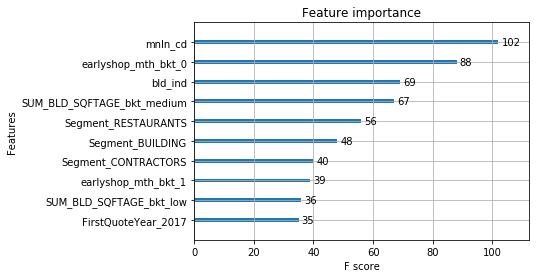

In [27]:
# plot feature importance
plot_importance(model, max_num_features=10)
plt.show()


This is pretty buggy. Graphviz has some dependencies in the evn site-packages. The above path works on my system. The diagrams are in the img file.   

Recommed the tree.export_graphviz method. the plot_tree func tends to fail on categorical

In [28]:
import pylab
import graphviz 
#plot_tree(model, num_trees=0, rankdir='UT', ax=None)

ModuleNotFoundError: No module named 'graphviz'

In [ ]:
#to_graphviz(model, num_trees=0, rankdir='UT', yes_color='#0000FF', no_color='#FF0000')

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf = tree.DecisionTreeClassifier(max_depth=3) #class_weight="balanced")
clf = clf.fit(X, np.ravel(y))


In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None,  feature_names=X.columns,  
class_names=None,  filled=True, rounded=True, special_characters=True) 


graph = graphviz.Source(dot_data)  

graph.render('img/dtree_render',view=True)

In [ ]:
X.shape

In [30]:
# manually select features IOT preserve column names
indices = np.argsort(importances)[::-1][:60]
feat_top = X.columns[indices][0:60]
cat_df = X[feat_top]

In [31]:
# model_re = SelectFromModel(model, threshold='.25*mean', prefit=True)
# X_re = model_re.transform(X)
# cat_df = pd.DataFrame(X_re)
# cat_df.shape   

In [32]:

cat_df.to_csv('../data/processed3/cat_df.csv', index=False)